### IS727272 - Cordero Hernández, Marco Ricardo

# Exercise 4.3.6 Fashion Classification

In this exercise we will implement a multilayer neural network for multiple classification.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
%matplotlib inline

## Fashion-MNIST Dataset
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

https://github.com/zalandoresearch/fashion-mnist

In [3]:
labels_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Fashion NN/', 'labels')
images_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/Fashion NN/', 'data')

with open(labels_path,'rb') as lbpath:
    labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
        
print(images_path)

with open(images_path,'rb') as imgpath:
    images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

print('images', images.shape)
print('labels', labels.shape)

/content/drive/MyDrive/Colab Notebooks/Fashion NN/data
images (60000, 784)
labels (60000,)


### Get 4 different classes
Let's get classes:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
Drop all other classes in next cell:

In [4]:
todrop = [4, 5, 6, 7, 8, 9]
for i in todrop:
    idxs = (labels == i)
    images = images[~idxs]
    labels = labels[~idxs]

print(images.shape, labels.shape)

(24000, 784) (24000,)


In [5]:
k = 4
for i in range(k):
    print('class ' + str(i), sum(labels == i))

class 0 6000
class 1 6000
class 2 6000
class 3 6000


### Show some examples

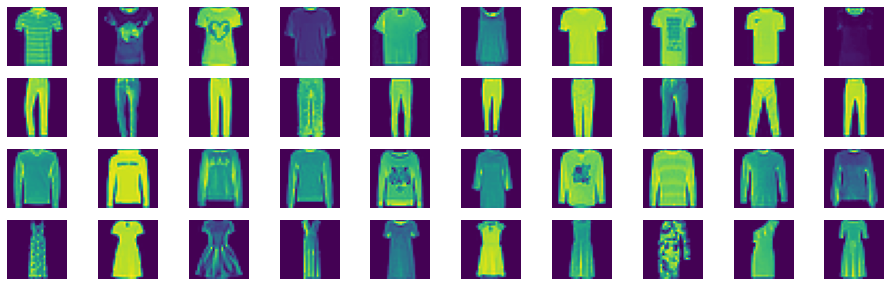

In [6]:
cols = 10
rows = 4
fig, axs = plt.subplots(rows, cols, figsize=(16, 5))
for i in range(rows):
    img = 0
    l = np.nonzero(labels == i)
    for j in np.random.choice(l[0], cols):
        axs[i, img].axis('off')
        hm = images[j, :].reshape(28, 28)
        axs[i, img].imshow(hm.astype(np.uint8))
        img += 1

## Normalizing and splitting data

Each pixel value is from 0 to 255, so we will normalize the data dividing the pixel values by 255. Then, we will split the dataset using the normalized values, laels, a test size of 30% and a random state equals 1.

In [7]:
#Normalize
img_norm = images / 255

#Split dataset
X_train, X_test, y_train, y_test = train_test_split(img_norm, labels, test_size = 0.3, random_state = 1)

print('Train dataset:', X_train.shape, y_train.shape)
print('Test dataset:', X_test.shape, y_test.shape)

for i in range(k):
    print('Train class ' + str(i), sum(y_train == i))
    print('Test class ' + str(i), sum(y_test == i))

Train dataset: (16800, 784) (16800,)
Test dataset: (7200, 784) (7200,)
Train class 0 4132
Test class 0 1868
Train class 1 4163
Test class 1 1837
Train class 2 4287
Test class 2 1713
Train class 3 4218
Test class 3 1782


## Implementing activation function

When classifying more than two classes, it is standrad to use a softmax as ouput layer:


$$
a_k(x_i) =\frac{e^{z_k}}{\sum_{j}^{K}e^{z_{j}}}
$$

For the activation functions and their derivatives in the hidden layers we will use the sigmoid and the tanh functions:

Sigmoid:

$$
g(z) = \frac{1}{1 + \mathcal{e}^{-z}}
$$
$$
g'(z) = g(z) * (1 - g(z))
$$

Tanh():

$$
g(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}
$$
$$
g'(z) = (1 - (g(z)^2)
$$

We will implement the $g(z)$ and $g'(z)$ functions as sigma and d_sigma functions. In these sigma functions we can choose which type of activation function to implement:

In [8]:
# z = w * x

def softmax(z):
    s = np.zeros(len(z))
    exp_z = np.exp(z)
    r, c = exp_z.shape

    for i in range(r):
      summ = 0
      for j in range(c):
        summ += exp_z[i][j]
      exp_z[i] /= summ

    return exp_z

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def tanhz(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def sigma(z, activation):
    if activation == 'sigmoid':
      return sigmoid(z)
    if activation == 'tanh':
      return tanhz(z)
    if activation == 'softmax':
      return softmax(z)

def d_sigma(z, activation):
    if activation == 'sigmoid':
      return z * (1 - z)
    if activation == 'tanh':
      return 1 - z**2

## Implement prediction and accuracy using softmax

In [9]:
def predict(A):
    h = softmax(A)
    y_hat = np.zeros(len(h))

    for j in range(len(h)):
      ymax = np.max(h[j])
      pos, = np.where(h[j] == ymax)
      y_hat[j] = pos

    return y_hat

def accuracy(A, y):
    y_hat = predict(A)
    tptn1 = (y == y_hat)
    tptn = np.sum(tptn1)

    return tptn/len(y)

### Testing your code

In [10]:
xw = np.array([[.1, .2, .1, .3]])
out = softmax(xw)
print('softmax:\n', out)
print('sum =', out.sum())
print('prediction =', predict(out))

print('\nTwo examples:')
xw = np.array([[.1, .2, .1, .3],
               [.02, .4, .8, .0]])
out = softmax(xw)
print('softmax:\n', out)
print('sum =', out.sum(axis=1))
print('prediction =', predict(out))

softmax:
 [[0.23112977 0.25543791 0.23112977 0.28230254]]
sum = 1.0000000000000002
prediction = [3.]

Two examples:
softmax:
 [[0.23112977 0.25543791 0.23112977 0.28230254]
 [0.17781079 0.26000998 0.38788932 0.1742899 ]]
sum = [1. 1.]
prediction = [3. 2.]


Expected output:

```
softmax:
 [[ 0.23112977  0.25543791  0.23112977  0.28230254]]
sum = 1.0
prediction = [3]

Two examples:
softmax:
 [[ 0.23112977  0.25543791  0.23112977  0.28230254]
 [ 0.17781079  0.26000998  0.38788932  0.1742899 ]]
sum = [ 1.  1.]
prediction = [3 2]
```

## Xavier initialization

Their major goal is to prevent gradient vanishing and too-large weight problems, the formula for a normal distribution is as follows:

$$
W_l = randn(n_l, n_{l-1}) * \sqrt{2 / (n_{l-1} + n_l)}
$$

In [11]:
# nx, number of features
# nh, number of hidden neurons
# ny, number of output neurons
def Xavier_init_w(nx, nh, ny):
    np.random.seed(1)
    W1 = np.random.randn(nh, nx) * ((2 / (nh + nx)) ** 0.5)
    b1 = np.zeros(shape = (1, nh))
    W2 = np.random.randn(ny, nh) * ((2 / (ny + nh)) ** 0.5)
    b2 = np.zeros(shape = (ny, 1))
    W = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return W

## Forward Propagation

In [12]:
# Implement forward propagation to calculate output probabilities
def forward(x, W):
    W1 = W['W1']
    b1 = W['b1']
    W2 = W['W2']
    b2 = W['b2']
    
    Z2 = np.dot(x, W1.T) + b1
    A2 = sigma(Z2, 'tanh')
    Z3 = np.dot(A2, W2.T) + b2.T
    A3 = sigma(Z3, 'softmax')
    
    Z = {"Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
    return A3, Z

### Testing code

In [13]:
m, n = X_train.shape
print(X_train.shape)
W = Xavier_init_w(n, nh = 2, ny = 2)
A3, Z = forward(X_train, W)
print('W1 =', W['W1'].shape)
print('W2 =', W['W2'].shape)
print('prediction =', predict(A3[:10]))

(16800, 784)
W1 = (2, 784)
W2 = (2, 2)
prediction = [1. 1. 1. 1. 0. 1. 0. 0. 1. 1.]


Expected output:

```
W1 = (2, 784)
W2 = (2, 2)
prediction = [1 1 1 1 0 1 0 0 1 1]
```

## Cost Function

Cross entropy error function for multi-class output is:

$$
E = - \sum_{k}^{K} y_k log(a_k)
$$

Where we have softmax function:

$$
a_k = g_k(x_i) = \frac{e^{z_k}}{\sum_{j}^{K}e^{z_{j}}}
$$

Then, the cost for all examples:

$$
J(w) = \frac{1}{m}\sum_{i=1}^{m} E_i
$$

\begin{equation*}
  \frac{\partial{E_i}}{\partial z_k} = \begin{cases}
    a_k - 1(y_i = k) &\text{if $y_k$ is the class}\\
    a - y &\text{if $y$ is one-hot}
  \end{cases}
\end{equation*}



In [14]:
def onehot(y4, k):
    m = len(y4)
    yk = np.zeros((m, k))

    for i in range(m):
      for j in range(k):
        if y4[i] == j:
          yk[i][j] = 1

    return yk

def cost(A, y):  
    m, k = A.shape
    yk = onehot(y, k)
    lA = np.log(A)
    c = yk * lA
    E = (-1 / m) * np.sum(c)

    return E


In [15]:
out = np.array([[0.2, 0.1, 0.4, 0.3],
                [0.1, 0.2, 0.3, 0.4]])
t = np.array([1, 2])
print('cost =', cost(out, t))
out[range(len(t)), t] -= 1
print(out)

cost = 1.753278948659991
[[ 0.2 -0.9  0.4  0.3]
 [ 0.1  0.2 -0.7  0.4]]


Expected output:

```
cost = 1.75327894866
[[ 0.2 -0.9  0.4  0.3]
 [ 0.1  0.2 -0.7  0.4]]
```

## Backward propagation

1. For output layer $\delta_l = \frac{1}{m} a - y$
2. For hidden layer $\delta_l = g'(z_l) * \delta_{l+1} w_l$

**Gradients**

1. For bias term, $\frac{\partial}{\partial b_l} = sum(\delta_{l+1})$, recall that shape of $\frac{\partial}{\partial b_l}$ must match the shape of $b_l$
2. For weights, $\frac{\partial}{\partial w_l} = \delta_{l+1} a_l$

In [16]:
def backward(W, Z, x, y):
    m = x.shape[0]
    
    W1 = W['W1']
    W2 = W['W2']
    A2 = Z['A2']
    A3 = Z['A3']
    Z2 = Z['Z2']
    Z3 = Z['Z3']

    y = onehot(y, 4)
    
    d3 = (1/m) * (A3 - y)
    dW2 = np.dot(d3.T, A2)
    db2 = np.sum(d3, axis = 0)
    d2 = d_sigma(Z2, 'tanh') * np.dot(d3, W2)
    dW1 = np.dot(d2.T, x)
    db1 = np.sum(d2, axis = 0)
    
    db2 = db2.reshape(-1,1)
    
    grad = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return grad

## Model implementation

In [17]:
def model(x, y, nh, alpha = 0.1, epochs = 1000, debug = False):
    np.random.seed(2)
    m, nx = x.shape
    ny = 4 # number of classes

    W = Xavier_init_w(nx, nh, ny)
    A3, Z = forward(x, W)
    print('Initial cost: ', cost(A3, y))
    
    J = []
    for i in range(epochs):
        A3, Z = forward(x, W)
        J.append(cost(A3, y))
        grad = backward(W, Z, x, y)

        W['W1'] = W['W1'] - alpha * grad['dW1']
        W['W2'] = W['W2'] - alpha * grad['dW2']
        W['b1'] = W['b1'] - alpha * grad['db1']
        W['b2'] = W['b2'] - alpha * grad['db2']

        if i % 200 == 0 and debug == True:
            print('epoch', i, 'cost', J[i])
    print('Final cost:', J[epochs-1])
    return W, J

### Testing the code

In [ ]:
start = time.time()
W1, J1 = model(X_train, y_train, nh = 10, alpha = 0.00005, epochs = 800, debug = True)
end = time.time()

print(f'Elapsed time: {(end - start)/60} minutes')

A3, Z = forward(X_train, W1)
acc = accuracy(A3, y_train)
print(f'Accuracy: {acc}')

plt.plot(J1)
plt.title('Cost over epochs')
plt.ylabel('Cost')

Initial cost:  1.342038674937137
epoch 0 cost 1.342038674937137


In [ ]:
def confusion_matrix(A, y):
    m, k = A.shape

    mat = np.zeros((k, k))
    y_hat = predict(A)
    y_hat = y_hat.reshape(-1, 1)
    y = y.reshape(-1, 1)

    for j in range(m):
      for kk in range(k):
        for ll in range(k):
          if (y[j] == kk):
            if y_hat[j] == ll:
              mat[ll][kk] += 1

    return mat

In [ ]:
def plot_confusion_matrix(values, classes):
    import itertools
    m, n = values.shape

    accuracy = np.trace(values) / float(np.sum(values))
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(values, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title('Confusion matrix')
    plt.colorbar()

    marks = np.arange(len(classes))
    plt.xticks(marks, classes, rotation=45)
    plt.yticks(marks, classes)

    thresh = values.max() / 2
    for i, j in itertools.product(range(m), range(n)):
        plt.text(j, i, "{:,}".format(values[i, j]),
                 horizontalalignment="center",
                 color="white" if values[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(values = mat, classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress'])
print(mat)